# Basics with images

* Find this notebook at `EpyNN/epynnlive/dummy_image/train.ipynb`.
* Regular python code at `EpyNN/epynnlive/dummy_image/train.py`.

Run the notebook online with [Google Colab](https://colab.research.google.com/github/Synthaze/EpyNN/blob/main/epynnlive/dummy_image/train.ipynb).

**Level: Intermediate**

In this notebook we will review:

* Handling numerical data image to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Convolutional Neural Network (CNN) for binary classification tasks.
* Overfitting of the model to the training data and impact of Dropout regularization.

**It is assumed that the following *basics* notebooks were already reviewed:**

* [Basics with Perceptron (P)](../dummy_boolean/train.ipynb)
* [Basics with string sequence](../dummy_string/train.ipynb)
* [Basics with numerical time-series](../dummy_time/train.ipynb)

**<font color='red'>This notebook does not enhance, extend or replace EpyNN's documentation.</font>**

**Relevant documentation pages for the current notebook:**

* [Fully Connected (Dense)](https://epynn.net/Dense.html)
* [Convolution (CNN)](https://epynn.net/Convolution.html)
* [Pooling (CNN)](https://epynn.net/Pooling.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, grayscale images were generated by random selection of tones. Each image represents one sample features object. Such random features may have been altered - or not - by setting a fraction of the pixel to the highest tone level in the palette.

The goal of the neural network training is to build a classifier able to detect if a presumably random image has been altered or not. Said differently, we are going to try detecting deviation or anomaly with respect to the expected distribution of randomly chosen tones within the image.

In [1]:
# EpyNN/epynnlive/dummy_image/train.ipynb
# Install dependencies
!git clone https://github.com/synthaze/EpyNN
!pip3 install -r EpyNN/requirements.txt
import sys
sys.path.insert(1, '/content/EpyNN')

# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import epynn.initialize
from epynn.commons.maths import relu, softmax
from epynn.commons.library import (
    configure_directory,
    read_model,
)
from epynn.network.models import EpyNN
from epynn.embedding.models import Embedding
from epynn.convolution.models import Convolution
from epynn.pooling.models import Pooling
from epynn.flatten.models import Flatten
from epynn.dropout.models import Dropout
from epynn.dense.models import Dense
from epynnlive.dummy_image.prepare_dataset import prepare_dataset
from epynnlive.dummy_image.settings import se_hPars


########################## CONFIGURE ##########################
random.seed(0)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=750)

Let's inspect what we retrieved.

In [2]:
print(len(X_features))
print(X_features[0].shape)

750
(28, 28, 1)


We retrieved sample features describing ``750`` samples.

For each sample, we retrieved  features as a three-dimensional array of shape ``(width, height, depth)``.

In the context, remember that the ``depth`` dimension represents the number of channels which encode the image. While the depth of any RGB image would be equal to 3, the depth of a grayscale image is equal to one.

Let's recall how this looks.

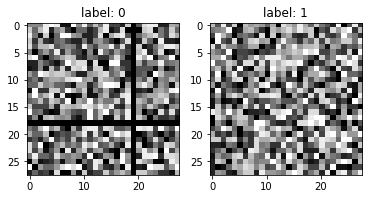

In [3]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(X_features[Y_label.index(0)], cmap='gray')
ax0.set_title('label: 0')

ax1.imshow(X_features[Y_label.index(1)], cmap='gray')
ax1.set_title('label: 1')

plt.show()

The first image is associated with a ``label: 0`` (non-random image) while the second is associated with ``label: 1`` (random image).

In terms of pixel tones distribution for the zero (black) tone.

In [4]:
print(np.count_nonzero(X_features[Y_label.index(0)] == 0))    # Manipulated image
print(np.count_nonzero(X_features[Y_label.index(1)] == 0))    # Random image

96
59


Indeed there are 12 more white pixels in the image with ``label: 0`` compared to the image with ``label: 1``. Since we expected 10% of the image pixels to be altered with the highest tone - which renders to white in matplotlib - we can then be somewhat confident and go ahead.

Note that double-checking the data is important: nobody wants to waste a day of work at trying to fit inconsistent data.

## Feed-Forward (FF)

We will first engage in designing a Feed-Forward network.

### Embedding

We first instantiate the embedding layer which is on top of the network.

In [5]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

Note that we set ``X_scale=True`` in order to normalize the whole input array of sample features within \[0, 1\]. Although the neural network may theoretically achieve this normalization by itself, it may be slowing down training and convergence. In general, it is thus recommended to apply normalization within \[0, 1\] or, alternatively, \[-1, 1\].

We have also set a ``batch_size=32`` which represents the number of samples from which gradients are computed and parameters updated. There are ``N_SAMPLES/batch_size`` parameters update per training epoch.

### Flatten-(Dense)n with Dropout

We start with a Feed-Forward network which requires the use of a *Flatten* layer before the first *Dense* layer in order to reshape image data of shape ``(HEIGHT, WIDTH, DEPTH)`` into ``(HEIGHT * WIDTH * DEPTH)`` or simply ``(N_FEATURES)``.

In [6]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a first *dropout1* between the *flatten* and *hidden_dense* layer as well as a second one between *hidden_dense* and *dense* to anticipate overfitting problems.

In [7]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Let's train the network for 100 epochs.

In [8]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.781 Cost: 0.1455 - TIME: 12.33s RATE: 8.11e+00e/s TTC: 0s      

+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                               Experiment                               |
|       |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                        |
+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 |  0.506   | 0.540 | 0.273  | 0.266 | 1635012582_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 |  0.624   | 0.496 | 0.232  | 0.254 | 1635012582_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 |  0.684   | 0.512 | 0

We can already observe that the model could reproduce the training data well, in contrast to the validation data.

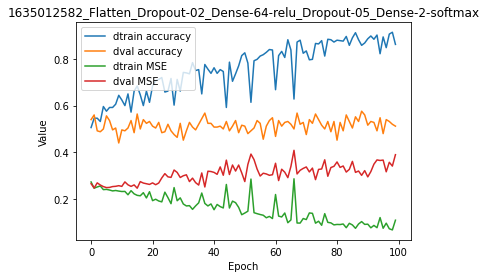

In [9]:
model.plot(path=False)

The plot shows unambiguously that, even when using two *Dropout* layers, there is major overfitting with virtually no relevance of the model with regards to validation data.

For code, maths and pictures behind *Dense* and *RNN* layers, follow these links:

* [Dropout - Regularization](https://epynn.net/Dropout.html)
* [Fully Connected (Dense)](https://epynn.net/Dense.html)

## Convolutional Neural Network (CNN)

Convolutional networks are generally preferred when dealing with image data. They are a particular kind of Feed-Forward network whose specific Convolution layer is designed to extract relevant data with respect to spatial organization.

By comparison, the *Dense* layer does not make assumptions about the relationship between data points at index ``i`` and ``i + 1``. In contrast, the *Convolution* layer will process data points related through coordinates within groups defined by ``filter_size``.

### Embedding

Using same embedding configuration than above.

In [10]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

Time to explain one thing:

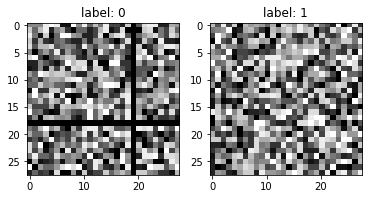

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(X_features[Y_label.index(0)], cmap='gray')
ax0.set_title('label: 0')

ax1.imshow(X_features[Y_label.index(1)], cmap='gray')
ax1.set_title('label: 1')

plt.show()

There is a reason why we did not make the random image non-random by simply randomly setting values to zero.

As stated above, CNN are best to **detect patterns through space**. We do not expect any pattern following a random modification of values within one image.

If we have had done so, we would not expect the CNN to do better than the classical Feed-Forward, *Dense* layer based network.

Instead, we have voluntarily alterated the random image with a clear pattern. Visually a black cross in the image. Therefore, we may expect the CNN to overperform because there is actually a space-defined pattern to detect.

### Conv-Pool-Flatten-Dense

When dealing with CNN, the specific *Convolution* layer often comes along with a so-called *Pooling* layer.

Such a *Pooling* layer may be seen as a data compression layer. It will let pass through one value per ``pool_size`` window which is often one of the two minimum or maximum extrema.

In [12]:
name = 'Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

convolution = Convolution(unit_filters=6, filter_size=(4, 4), activate=relu)

pooling = Pooling(pool_size=(2, 2))

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, convolution, pooling, flatten, dense]

model = EpyNN(layers=layers, name=name)

Note that while we used a single *Convolution-Pooling* block here, these are often stacked in the design of CNNs.

Our *Convolution* layer uses ``6`` filters or kernels with ``filter_size=(4, 4)``.

Practically speaking, ``6`` filters means the output shape will be ``(m, .., .., 6)`` while the input shape was ``(m, ..., ..., DEPTH)`` or ``(m, ..., ..., 1)`` in this example.

Considering ``filter_size=(4, 4)``, it means the output shape will be ``(m, h // 4, w // 4, 6)`` while the input shape was ``(m, h, w, 1)``.

Since the numerical dimensions of the input were ``(m, 28, 28, 1)``, we then expect the output of the *Convolution* layer to have shape ``(m, 7, 7, 6)``.

Note that there is another *Convolution* layer argument, such as ``strides=()``. When not provided, ``strides=filter_size``. Strides describe by how much the convolution window defined by ``filter_size=(4, 4)`` will jump between each iteration through image dimensions. 

We pass for now, and will instead set the default for the ``end`` argument value below.

In [13]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end=None)

--- EpyNN Check ---                                                                                 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
shape: (32, 28, 28, 1)
Layer: Convolution
compute_shapes: Convolution
initialize_parameters: Convolution
forward: Convolution
shape: (32, 7, 7, 6)
Layer: Pooling
compute_shapes: Pooling
initialize_parameters: Pooling
forward: Pooling
shape: (32, 3, 3, 6)
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
shape: (32, 54)
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
shape: (32, 2)
Layer: Dense
backward: Dense
shape: (32, 54)
compute_gradients: Dense
Layer: Flatten
backward: Flatten
shape: (32, 3, 3, 6)
compute_gradients: Flatten
Layer: Pooling
backward: Pooling
shape: (32, 7, 7, 6)
compute_gradients: Pooling
Layer: Convolution
backward: Convolution
shape: (32, 28, 28, 1)
compute_gradients: Convolution
Layer: Embedding
backward

When ``end`` is provided with ``None`` or simply by default, the ``.initialize()`` method returns EpyNN check logs which include shapes for output of forward and backward propagation and for every layer.

Note the assumption we made about the output shape of the *Convolution* layer was right, it is indeed ``(m, 7, 7, 6)`` with *m* equals to the ``batch_size`` we set upon instnatiation of the *Embedding* layer.

Let's train the model.

In [14]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.781 Cost: 0.1636 - TIME: 13.11s RATE: 7.63e+00e/s TTC: 0s      

+-------+-------------+----------+----------+-------+--------+-------+--------------------------------------------------------------------+
| epoch |    lrate    |  lrate   | accuracy |       |  MSE   |       |                             Experiment                             |
|       | Convolution |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                    |
+-------+-------------+----------+----------+-------+--------+-------+--------------------------------------------------------------------+
|   0   |  1.00e-03   | 1.00e-03 |  0.482   | 0.484 | 0.289  | 0.277 | 1635012595_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax |
|  10   |  1.00e-03   | 1.00e-03 |  0.540   | 0.528 | 0.252  | 0.247 | 1635012595_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax |
|  20   |  1.00e-03   | 1.00e-03 |  0.622   | 0.604 | 0.23

We readily observe the model could converge to reproduce both training and validation data at some extent.

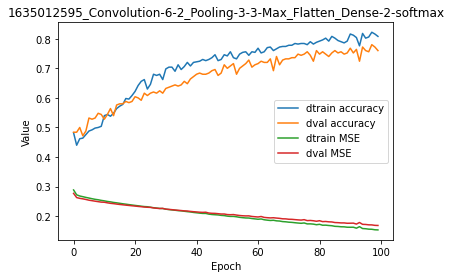

In [15]:
model.plot(path=False)

Looking at the plot, it seems clear that:

* The model is converging and has not completed convergence.
* There is overfitting seen from the first training iterations.

For code, maths and pictures behind the convolution and pooling layers, follow these links:

* [Convolution (CNN)](https://epynn.net/Convolution.html)
* [Pooling (CNN)](https://epynn.net/Pooling.html)

## Write, read & Predict

A trained model can be written on disk such as:

In [16]:
model.write()

# model.write(path=/your/custom/path)

Make: /media/synthase/beta/EpyNN/epynnlive/dummy_image/models/1635012595_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax.pickle


A model can be read from disk such as:

In [17]:
model = read_model()

# model = read_model(path=/your/custom/path)

We can retrieve new features and predict on them.

In [18]:
X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_scale=True)

Results can be extracted such as:

In [19]:
for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

0 0 [0.72836536 0.27163464]
1 0 [0.56434711 0.43565289]
2 1 [0.30717667 0.69282333]
3 1 [0.40234684 0.59765316]
4 0 [0.84712438 0.15287562]
5 0 [0.80588772 0.19411228]
6 1 [0.27219075 0.72780925]
7 1 [0.33549057 0.66450943]
8 0 [0.63908393 0.36091607]
9 1 [0.22657009 0.77342991]
